In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization,Dropout
from keras.models import Model, model_from_json
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 64, 64

#Location of the images
train_data_dir = "/home/pragya/Kaggle/Plant Seedlings Classification/train"
val_data_dir = "/home/pragya/Kaggle/Plant Seedlings Classification/validation"
nb_epochs = 24
batch_size = 8
FC_SIZE = 256
NB_IV3_LAYERS_TO_FREEZE = 172

input_shape = (img_width, img_height, 3)

In [3]:
def get_no_files(dir):
    if not os.path.exists(dir):
        print("Error: Invalid directory")
        #TO DO: Error Handling
        return 0
    count = 0
    for r, dirs, files in os.walk(dir):
        for dr in dirs:
            count += len(glob.glob(os.path.join(r, dr + "/*")))
    return count

In [4]:
def freeze_all_layers(base_model):
    for layer in base_model.layers:
        layer.trainable=False
    

In [5]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(FC_SIZE, activation='elu')(x) #new FC layer, random init
    x = Dense(FC_SIZE, activation='elu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(inputs=base_model.input, outputs=predictions)
    return model    

In [6]:
def image_to_dataset(add,rows,cols):
    """ Returns:
        x_train: numpy array of images as [#images,rows,cols,#channels]
        y_train: numpy array of lables as [#images,1]
    """
    if not os.path.exists(add):
        print("Error: Invalid directory")
        return 0
    for path , dirname , filenames in os.walk(add):
        if dirname:
            classes = dirname
        if filenames:
            print("Getting data from: " + path)
            for imagename in filenames:
                img = cv2.imread(path + "/" + imagename, cv2.IMREAD_COLOR)#img_to_array(load_img(path + "/" + imagename, target_size=(rows, cols)))
                img = cv2.resize(img,(rows,cols))
                #print(img.shape)
                img = np.expand_dims(img, axis = 0)
                if 'x_train' in locals():
                    x_train = np.append(x_train, img, axis = 0)
                    b = np.zeros((1,1))
                    b[0,0] = classes.index(os.path.basename(path))
                    y_train = np.append(y_train, b, axis = 0)
                else:
                    x_train = img
                    y_train = np.zeros((1,1))
                    y_train[0,0] = np.array([int(classes.index(os.path.basename(path)))])
    return x_train, y_train.astype(int), classes

In [7]:
def mask(image_stack):
    for index in range(0,image_stack.shape[0]):
        img = image_stack[index]
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        lower_green = np.array([30,65,0])
        upper_green = np.array([255,255,255])

        mask = cv2.inRange(hsv, lower_green, upper_green)
        image_stack[index] = cv2.bitwise_and(img, img, mask=mask)
    return image_stack

In [ ]:
nb_train_samples = get_no_files(train_data_dir)
nb_classes = len(glob.glob(train_data_dir + "/*"))
nb_val_samples = get_no_files(val_data_dir)
nb_epochs = int(nb_epochs)
batch_size = int(batch_size)

In [ ]:
x_train,y_train,classes = image_to_dataset("../train",rows = img_width,cols = img_height)
x_val,y_val,_ = image_to_dataset("../validation",rows = img_width,cols = img_height)

Getting data from: ../train/Common wheat
Getting data from: ../train/Small-flowered Cranesbill
Getting data from: ../train/Sugar beet


In [ ]:
# data prep
x_train = mask(x_train)
x_val = mask(x_val)
y_train = to_categorical(y_train,nb_classes)
y_val = to_categorical(y_val,nb_classes)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [ ]:
# setup model
base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False) #include_top=False excludes final FC layer
freeze_all_layers(base_model)
model = add_new_last_layer(base_model, nb_classes)

# transfer learning

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""history_tl = model.fit_generator(
    train_generator,
    nb_epoch=nb_epochs,
    steps_per_epoch=None,
    validation_data=validation_generator,
    nb_val_samples=nb_val_samples,
    class_weight='auto') 
"""
datagen.fit(x_train)
history_tl = model.fit_generator( 
    datagen.flow(x_train, y_train,batch_size=batch_size),
    validation_data=(x_val,y_val), 
    steps_per_epoch=int(nb_train_samples/batch_size), 
    epochs=nb_epochs,  
    validation_steps=int(nb_val_samples/batch_size))

In [15]:
#Save the model

# serialize model to JSON
model_json = model.to_json()
with open("plantSeed.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("plantSeed.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# load json and create model
json_file = open('plantSeed.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("plantSeed.h5")
print("Loaded model from disk")

Loaded model from disk


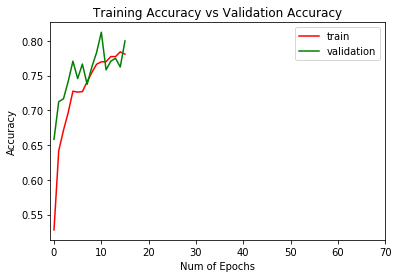

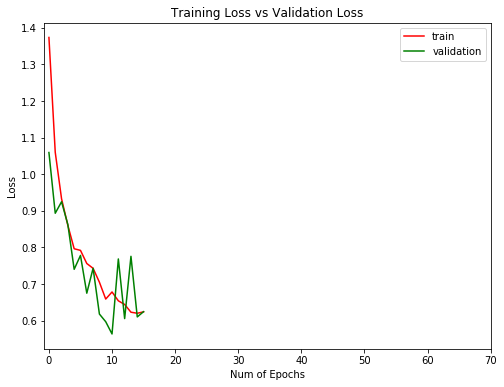

In [17]:
h=history_tl

plt.figure(0)
plt.plot(h.history['acc'],'r')
plt.plot(h.history['val_acc'],'g')
plt.xticks(np.arange(0, 80, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(h.history['loss'],'r')
plt.plot(h.history['val_loss'],'g')
plt.xticks(np.arange(0, 80, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
 
plt.show()